## Model Training

#### Importing required packages

In [140]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import randint


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

warnings.filterwarnings('ignore')
hyp=False

#### Importing the data

In [141]:
traindf = pd.read_csv('data/train.csv')
testdf = pd.read_csv('data/test.csv')

In [142]:
# Train data records
traindf.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [143]:
# Test Data Records
testdf.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


#### Train, Test & Split

Splitting the data in 80 - 20 ratio
- 80% for Training the models
- 20% for testing the model performance.

In [144]:
cols = list(traindf.columns)

X = traindf[cols[:-1]]
y = traindf[cols[-1]]

#### Transforming the data

- Transforming numerical data using MinMax Scaler
- Transforming categorical data using OneHotEncoder

In [145]:
# Creating a pipeline for Transformer

def transform_data(X):
    num_cols = X.select_dtypes(exclude="object").columns
    cat_cols = X.select_dtypes(include="object").columns

    minmax_scaler = MinMaxScaler()
    onehot_encoder = OneHotEncoder()

    preprocessor_train = ColumnTransformer(
        [
            ("LabelEncoder", onehot_encoder, cat_cols),
            ("MinMaxScaler", minmax_scaler, num_cols),
        ]
    )

    X = preprocessor_train.fit_transform(X)
    
    return X

In [146]:
X = transform_data(X)

In [147]:
#Encoding the Target Variable

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

In [148]:
# Creating mapping of target variable

mapping_df = pd.DataFrame([y,y_encoded]).T
mapping_df = mapping_df.rename(columns={'Unnamed 0': 'NObeyesdad_encoded'})
mapping_df = mapping_df.groupby(by = ['NObeyesdad','NObeyesdad_encoded']).size().reset_index()
mapping = dict(zip(mapping_df['NObeyesdad_encoded'],mapping_df['NObeyesdad']))

mapping

{0: 'Insufficient_Weight',
 1: 'Normal_Weight',
 2: 'Obesity_Type_I',
 3: 'Obesity_Type_II',
 4: 'Obesity_Type_III',
 5: 'Overweight_Level_I',
 6: 'Overweight_Level_II'}

#### Train, Test & Split

Splitting the data in 80 - 20 ratio
- 80% for Training the models
- 20% for testing the model performance.

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

#### Creating the Model Architecture

##### Creating Metrics Evaluation Function

In [150]:
from sklearn.metrics import precision_score, recall_score, f1_score

def kpis(y_true, y_pred):
    '''
    Finding Metrics of the data and sending an dataframe with accuracy, precision, recall, f1 score.
    '''
    # calculate accuracy for test set
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate weighted average precision and recall
    weighted_precision = precision_score(y_true, y_pred, average='weighted')
    weighted_recall = recall_score(y_true, y_pred, average='weighted')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')

    # Calculate macro-averaged precision and recall
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    return [accuracy, macro_precision, macro_recall, macro_f1, weighted_precision, weighted_recall, weighted_f1]

##### listing all models and training

In [151]:
models = {
    "RF": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(), 
    "CatBoost": cat.CatBoostClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "LightGBM": lgb.LGBMClassifier(),
}

model_names =list(models.keys())
model_func = list(models.values())
final_metrics = []

for i in range(len(model_names)):
    model = model_func[i]
    
    #Training the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate Metrics
    metrics = kpis(y_test, y_pred)

    final_metrics.append(metrics)
        

# Metrics DataFrame
metrics_df = pd.DataFrame(
        final_metrics, 
        index = model_names, 
        columns = ['accuracy', 'macro_precision', 'macro_recall', 'macro_f1', 'weighted_precision', 'weighted_recall', 'weighted_f1']
        )

Learning rate set to 0.091318
0:	learn: 1.6581168	total: 8.48ms	remaining: 8.47s
1:	learn: 1.4673870	total: 18.8ms	remaining: 9.38s
2:	learn: 1.3250017	total: 29.1ms	remaining: 9.66s
3:	learn: 1.2172019	total: 39.7ms	remaining: 9.88s
4:	learn: 1.1299537	total: 50.4ms	remaining: 10s
5:	learn: 1.0533423	total: 62.1ms	remaining: 10.3s
6:	learn: 0.9859698	total: 75ms	remaining: 10.6s
7:	learn: 0.9312805	total: 86.5ms	remaining: 10.7s
8:	learn: 0.8788393	total: 97.7ms	remaining: 10.8s
9:	learn: 0.8370752	total: 110ms	remaining: 10.8s
10:	learn: 0.7964383	total: 121ms	remaining: 10.9s
11:	learn: 0.7597033	total: 133ms	remaining: 11s
12:	learn: 0.7289655	total: 144ms	remaining: 10.9s
13:	learn: 0.7009698	total: 154ms	remaining: 10.9s
14:	learn: 0.6750034	total: 166ms	remaining: 10.9s
15:	learn: 0.6513084	total: 177ms	remaining: 10.9s
16:	learn: 0.6313488	total: 186ms	remaining: 10.8s
17:	learn: 0.6106073	total: 198ms	remaining: 10.8s
18:	learn: 0.5943152	total: 209ms	remaining: 10.8s
19:	lear

In [152]:
metrics_df

,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
RF,0.886079,0.876506,0.872350,0.873785,0.887275,0.886079,0.886058
XGBoost,0.900048,0.890126,0.889281,0.889639,0.900780,0.900048,0.900357
CatBoost,0.904143,0.894011,0.893572,0.893765,0.904622,0.904143,0.904359
AdaBoost,0.432803,0.333081,0.449234,0.345113,0.311315,0.432803,0.327594
LightGBM,0.900771,0.890838,0.889829,0.890281,0.901172,0.900771,0.900923


## Cross Validation

In [153]:
# Finding the best Model parameters using GridSearch CV 
# Doing it for RF and XGB

# Random Forest
if hyp:
    rf1 = RandomForestClassifier()
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    rf_grid_search = GridSearchCV(rf1, rf_param_grid, cv=5, scoring='accuracy')
    rf_grid_search.fit(X_train, y_train)

    best_rf_model = rf_grid_search.best_estimator_

    print("Random Forest Best Parameters:", rf_grid_search.best_params_)
    print("Random Forest Best Score:", rf_grid_search.best_score_)

    # XGBoost
    xgb_model = xgb.XGBClassifier()
    xgb_param_grid = {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200, 300]
    }
    xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='accuracy')
    xgb_grid_search.fit(X_train, y_train)

    best_xgb_model = xgb_grid_search.best_estimator_

    print("XGBoost Best Parameters:", xgb_grid_search.best_params_)
    print("XGBoost Best Score:", xgb_grid_search.best_score_)

In [154]:
# Finding the best Model parameters using RandomSearchCV

if hyp:
    # Random Forest
    rf1 = RandomForestClassifier()
    rf_param_dist = {
        'n_estimators': randint(100, 300),
        'max_depth': [None, 10, 20],
        'min_samples_split': randint(2, 10)
    }
    rf_random_search = RandomizedSearchCV(rf1, rf_param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
    rf_random_search.fit(X_train, y_train)

    best_rf_model = rf_random_search.best_estimator_

    print("Random Forest Best Parameters:", rf_random_search.best_params_)
    print("Random Forest Best Score:", rf_random_search.best_score_)

    # XGBoost
    xgb_model = xgb.XGBClassifier()
    xgb_param_dist = {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'n_estimators': randint(100, 300)
    }
    xgb_random_search = RandomizedSearchCV(xgb_model, xgb_param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
    xgb_random_search.fit(X_train, y_train)

    best_xgb_model = xgb_random_search.best_estimator_

    print("XGBoost Best Parameters:", xgb_random_search.best_params_)
    print("XGBoost Best Score:", xgb_random_search.best_score_)


In [155]:
# Known Parameters of LGBM - From Kaggle

best_params = {
    "objective": "multiclass",          # Objective function for the model
    "metric": "multi_logloss",          # Evaluation metric
    "verbosity": -1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 42,       # Random state for reproducibility
    "num_class": 7,                     # Number of classes in the dataset
    'learning_rate': 0.030962211546832760,  # Learning rate for gradient boosting
    'n_estimators': 500,                # Number of boosting iterations
    'lambda_l1': 0.009667446568254372,  # L1 regularization term
    'lambda_l2': 0.04018641437301800,   # L2 regularization term
    'max_depth': 10,                    # Maximum depth of the trees
    'colsample_bytree': 0.40977129346872643,  # Fraction of features to consider for each tree
    'subsample': 0.9535797422450176,    # Fraction of samples to consider for each boosting iteration
    'min_child_samples': 26             # Minimum number of data needed in a leaf
}

best_lgbm_model = lgb.LGBMClassifier(**best_params)

best_lgbm_model.fit(X_train, y_train)

y_pred = best_lgbm_model.predict(X_test)

metrics = kpis(y_test, y_pred)

# Metrics DataFrame
metrics_lgbm = pd.DataFrame(
        metrics, 
        columns = ['LGBM'], 
        index = ['accuracy', 'macro_precision', 'macro_recall', 'macro_f1', 'weighted_precision', 'weighted_recall', 'weighted_f1']
        )

metrics_lgbm

,LGBM
accuracy,0.906551
macro_precision,0.896623
macro_recall,0.896161
macro_f1,0.896358
weighted_precision,0.906947
weighted_recall,0.906551
weighted_f1,0.906718


In [156]:
# Known Parameters of XGB - From Kaggle

best_params = {'grow_policy': 'depthwise',
               'n_estimators': 982, 
               'learning_rate': 0.050053726931263504,
               'gamma': 0.5354391952653927, 
               'subsample': 0.7060590452456204,
               'colsample_bytree': 0.37939433412123275, 
               'max_depth': 23,
               'min_child_weight': 21,
               'reg_lambda': 9.150224029846654e-08,
               'reg_alpha': 5.671063656994295e-08}
best_params['booster'] = 'gbtree'
best_params['objective'] = 'multi:softmax'
best_params["device"] = "cuda"
best_params["verbosity"] = 0
best_params['tree_method'] = "gpu_hist"

best_xgb_model = xgb.XGBClassifier(**best_params)

best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)

metrics = kpis(y_test, y_pred)

# Metrics DataFrame
metrics_xgb = pd.DataFrame(
        metrics, 
        columns = ['XGB'], 
        index = ['accuracy', 'macro_precision', 'macro_recall', 'macro_f1', 'weighted_precision', 'weighted_recall', 'weighted_f1']
        )

metrics_xgb

,XGB
accuracy,0.907514
macro_precision,0.897815
macro_recall,0.897202
macro_f1,0.897484
weighted_precision,0.907579
weighted_recall,0.907514
weighted_f1,0.907521


## On Test Data

In [157]:
# Fallback mechanism
# Putting prediction as None for unseen categories

cat_cols = testdf.select_dtypes(include='object').columns

for i in list(testdf['CALC'].unique()):
    if i not in list(traindf['CALC'].unique()):
        var = i
        break

df = testdf[testdf['CALC']==var]
df['NObeyesdad'] = None
df

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
4023,24781,Female,20.0,1.66,60.0,yes,yes,3.0,3.0,Always,no,2.0,no,0.0,0.0,Always,Public_Transportation,None
7443,28201,Male,21.0,1.67,66.5,no,yes,2.0,3.0,Frequently,no,2.0,no,1.0,0.0,Always,Public_Transportation,None


#### Transforming the test data

In [158]:
testdf1 = testdf[testdf['CALC']!='Always']

testdf_transformed = transform_data(testdf1)

#### Predicting on Test Data

In [159]:
# Predictions

test_predictions_lgbm = best_lgbm_model.predict(testdf_transformed)

test_predictions_xgb = best_xgb_model.predict(testdf_transformed)


In [160]:

output_df = pd.DataFrame({'id': testdf1.id,
                       'NObeyesdad_lgbm': test_predictions_lgbm,
                       'NObeyesdad_xgb': test_predictions_xgb
                       })


output_df["NObeyesdad_lgbm"]  = output_df["NObeyesdad_lgbm"].map(mapping)
output_df["NObeyesdad_xgb"]  = output_df["NObeyesdad_xgb"].map(mapping)

output_df.head()

,id,NObeyesdad_lgbm,NObeyesdad_xgb
0,20758,Obesity_Type_II,Obesity_Type_II
1,20759,Overweight_Level_I,Overweight_Level_I
2,20760,Obesity_Type_III,Obesity_Type_III
3,20761,Obesity_Type_I,Obesity_Type_I
4,20762,Obesity_Type_III,Obesity_Type_III


In [161]:
left_out_preds = pd.DataFrame({'id': df.id,
                       'NObeyesdad_lgbm': None,
                       'NObeyesdad_xgb': None
                       })

In [162]:
output_df = pd.concat([output_df, left_out_preds]).sort_values(by='id')
output_df

,id,NObeyesdad_lgbm,NObeyesdad_xgb
0,20758,Obesity_Type_II,Obesity_Type_II
1,20759,Overweight_Level_I,Overweight_Level_I
2,20760,Obesity_Type_III,Obesity_Type_III
3,20761,Obesity_Type_I,Obesity_Type_I
4,20762,Obesity_Type_III,Obesity_Type_III
...,...,...,...
13835,34593,Overweight_Level_II,Overweight_Level_II
13836,34594,Overweight_Level_I,Overweight_Level_I
13837,34595,Insufficient_Weight,Insufficient_Weight
13838,34596,Normal_Weight,Normal_Weight


Text(0.5, 1.0, 'XGB Predictions Distribution')

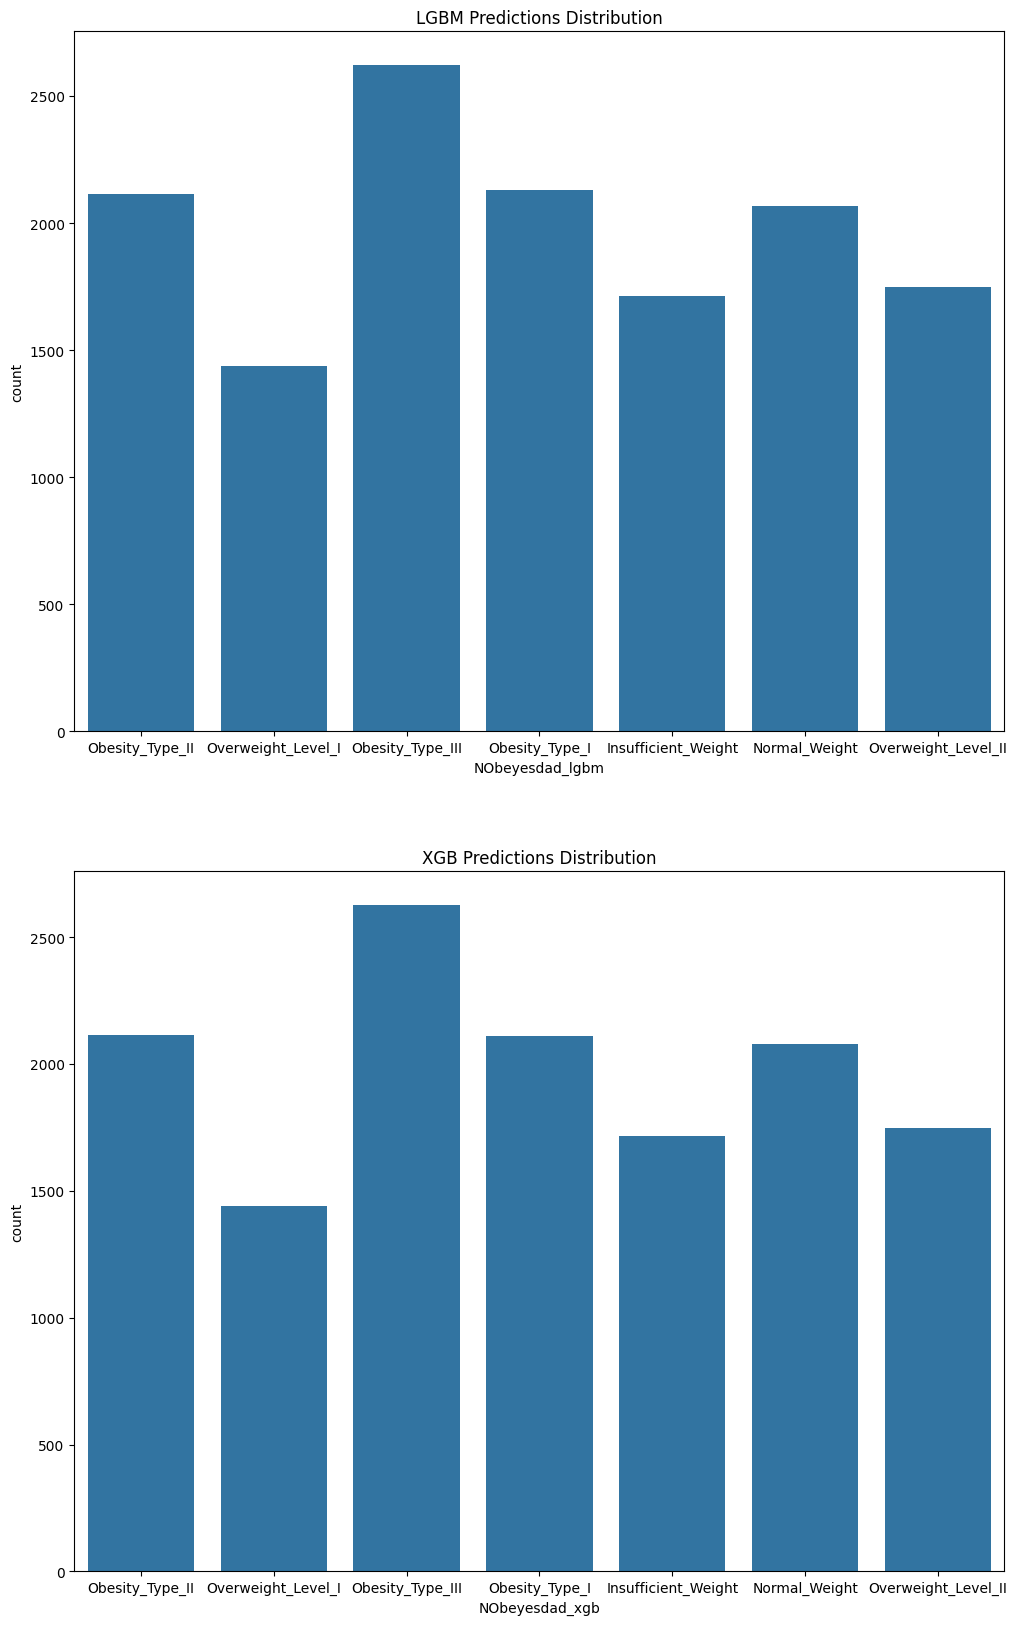

In [163]:
fig,ax = plt.subplots(2,1, figsize=(12,20))

sns.countplot(x = 'NObeyesdad_lgbm', data = output_df, ax=ax[0])
ax[0].set_title('LGBM Predictions Distribution')
sns.countplot(x = 'NObeyesdad_xgb', data = output_df, ax=ax[1])
ax[1].set_title('XGB Predictions Distribution')